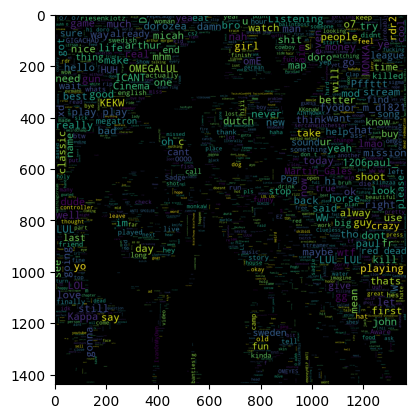

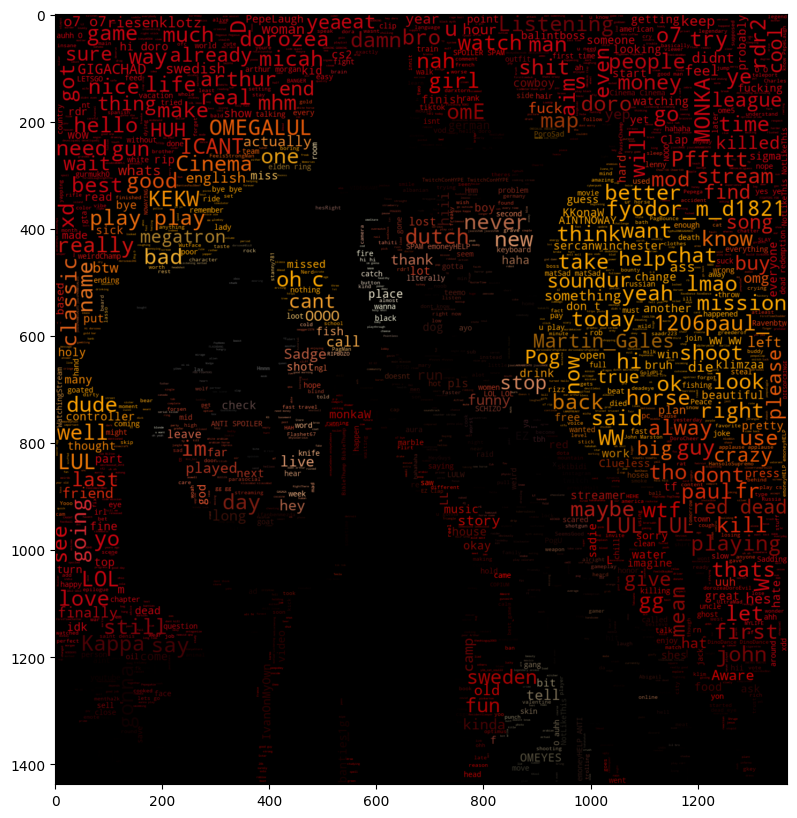

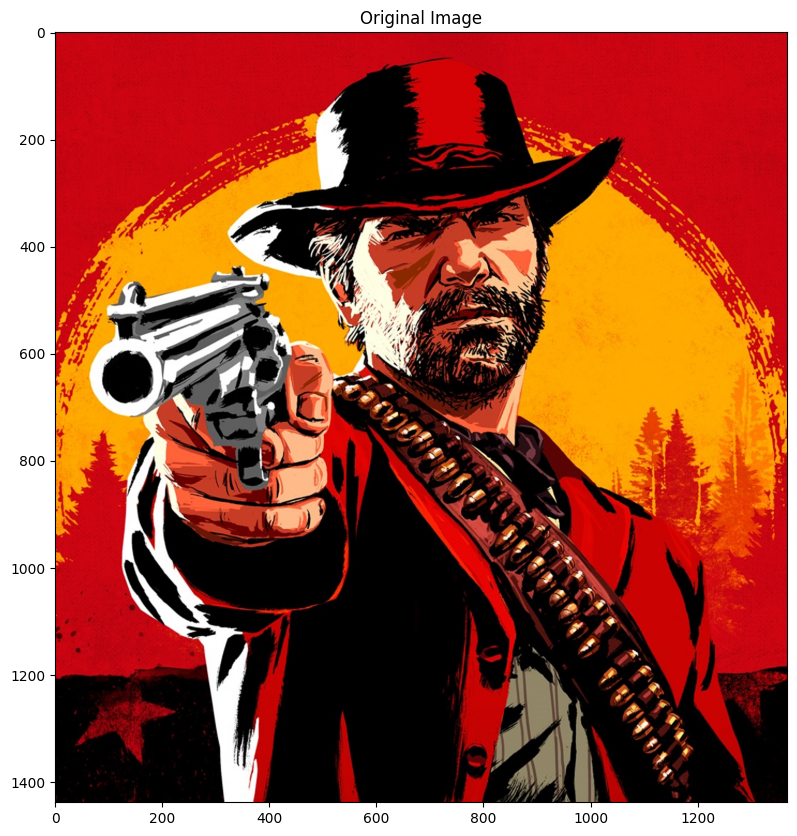

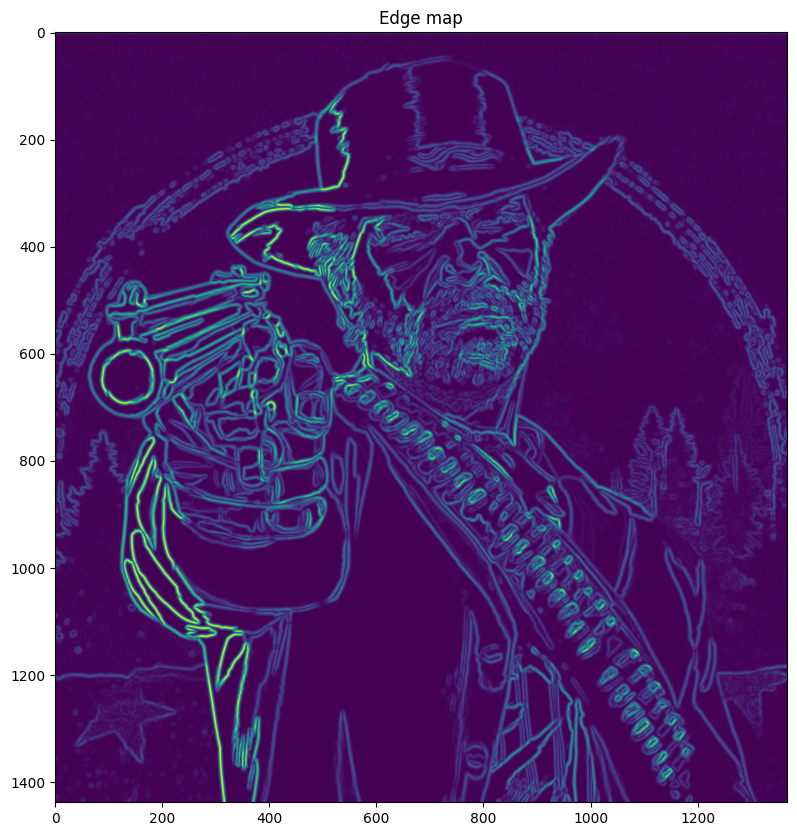

In [1]:
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_gradient_magnitude

from wordcloud import WordCloud, ImageColorGenerator

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()


import pandas as pd
import re

# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'


# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = "data\\"+file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

#filter
data = data[data['user'] != 'StreamElements']
data = data[data['user'] != 'Fossabot']
# Assuming 'data' is your DataFrame and 'stream' is the column you want to filter
streams_to_keep = [76, 77, 78, 80, 81, 82, 84, 85, 86, 89, 90, 91, 92, 93, 94, 95]

# Filter the DataFrame
data = data[data['stream'].isin(streams_to_keep)]

#data = data[~data['message'].str.contains('dimacut', case=False, na=False)]
data = data[~data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]

# load wikipedia text on rainbow
text = " ".join(data["message"])

# load image. This has been modified in gimp to be brighter and have more saturation.
parrot_color = np.array(Image.open(os.path.join(d, "reddead.jpg")))
# subsample by factor of 3. Very lossy but for a wordcloud we don't really care.
parrot_color = parrot_color[::3, ::3]

# create mask  white is "masked out"
parrot_mask = parrot_color.copy()
parrot_mask[parrot_mask.sum(axis=2) == 0] = 255

# some finesse: we enforce boundaries between colors so they get less washed out.
# For that we do some edge detection in the image
edges = np.mean([gaussian_gradient_magnitude(parrot_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
parrot_mask[edges > .08] = 255

# create wordcloud. A bit sluggish, you can subsample more strongly for quicker rendering
# relative_scaling=0 means the frequencies in the data are reflected less
# acurately but it makes a better picture
wc = WordCloud(max_words=2000, mask=parrot_mask, max_font_size=40, random_state=42, relative_scaling=0)

# generate word cloud
wc.generate(text)
plt.imshow(wc)

# create coloring from image
image_colors = ImageColorGenerator(parrot_color)
wc.recolor(color_func=image_colors)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
wc.to_file("rdr2_new.png")

plt.figure(figsize=(10, 10))
plt.title("Original Image")
plt.imshow(parrot_color)

plt.figure(figsize=(10, 10))
plt.title("Edge map")
plt.imshow(edges)
plt.show()